In [7]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

import matplotlib.pyplot as plt  # Import matplotlib's pyplot module

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A

    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for i in range(num_episodes):
        episode = []
        state = env.reset()
        for t in range(100):
            action_probs = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_pairs = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_pairs:
            sa_pair = (state, action)
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] for x in episode[first_occurrence_idx:]])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy

In [5]:
num_episodes = 50000
Q, policy = mc_control_epsilon_greedy(env, num_episodes, epsilon=0.1)

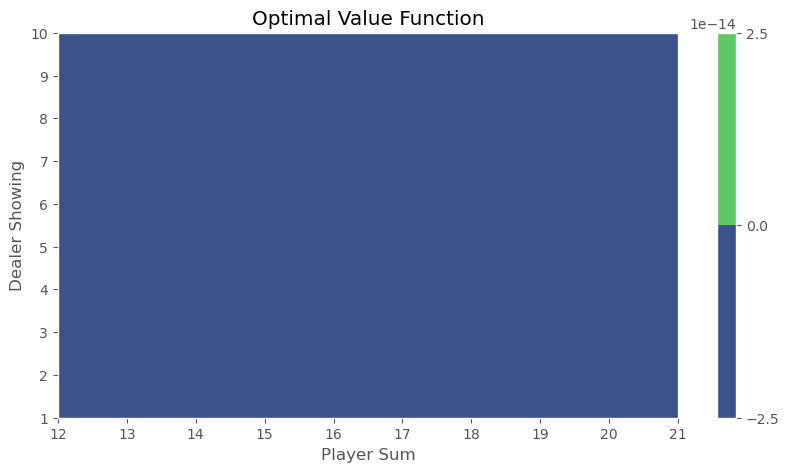

In [8]:
# Plot the optimal value function
def plot_value_function(Q):
    V = defaultdict(float)
    for state, actions in Q.items():
        action_value = np.max(actions)
        V[state] = action_value

    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.array([[V[(x, y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

    plt.figure(figsize=(10, 5))
    plt.contourf(X, Y, Z, cmap='viridis')
    plt.xlabel('Player Sum')
    plt.ylabel('Dealer Showing')
    plt.title('Optimal Value Function')
    plt.colorbar()
    plt.show()

plot_value_function(Q)